<a href="https://colab.research.google.com/github/amanmeka/DataScience/blob/main/Unit2/AmanMekaU2proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **UNIT 2 PROJECT:**

First we need to pip install preliz and importing numpy, pymc, arviz, and pandas:

In [ ]:
# Installing packages
!pip install preliz
import preliz as pz

import numpy as np
import pymc as pm
import arviz as az
import pandas as pd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 8.4 MB/s eta 0:00:00


# **Intro**

In this project I create a prediction model that is capable of predicting/determining the chance of GM Hikaru winning a chess game.

I chose this data mainly because I enjoy playing chess in my free time and I was interested in seeing how often the best players win their chess games. I also chose this dataset because I knew that I would be able to easily find a dataset with enough data.

# **Prior**
Our prior was part of the dataset but I seperated the main dataset into two parts: one was only of games from his first year (2014) and the other was from 2015 to present. I was able to acquire the dataset by using a website that scrubbed games from a popular chess game website and formatted it in csv. Although I have a prior dataset, not all of the games are worth putting through the model. In other words, there might be some games where he played with someone that had a much lower Elo than his, meaning that they were not as skilled as him. To be able to get a better prior we should restrict our data set to opponents that have an Elo higher than 2500. This makes our data set more reliable.

In [ ]:
# read in the hikaru prior games dataset
hikarupriorgames = 'https://raw.githubusercontent.com/amanmeka/DataScience/refs/heads/main/HikaruBlitzPrior.csv'

hikaruprior = pd.read_csv(hikarupriorgames)
hikaruprior = hikaruprior.query("opponentRating > 2500")

Then we can split the data into either wins or not wins. Not wins is either a draw or a loss. We can do this by querying the result column and counting the number of wins and not wins respectively.

Note: In chess there are multiple different ways that a game can end, therefore there will be a lot of queries that lead to one of 3 outcomes: win, loss, draw. In this case we are considering draws and losses under one category, not wins.

In [ ]:
winprior = hikaruprior.query('result == "win"').shape[0]
lossprior = hikaruprior.query('result == "resigned"').shape[0]
lossprior += hikaruprior.query('result == "checkmated"').shape[0]
lossprior += hikaruprior.query('result == "timeout"').shape[0]
lossprior += hikaruprior.query('result == "abandoned"').shape[0]
lossprior += hikaruprior.query('result == "50move"').shape[0]
lossprior += hikaruprior.query('result == "repetition"').shape[0]
lossprior += hikaruprior.query('result == "insufficient"').shape[0]
lossprior += hikaruprior.query('result == "timevsinsufficient"').shape[0]
lossprior += hikaruprior.query('result == "stalemate"').shape[0]
lossprior += hikaruprior.query('result == "agreed"').shape[0]
totalprior = winprior + lossprior

In [ ]:
winprior

32

In [ ]:
lossprior

10

In [ ]:
round((winprior/totalprior)*100,1)

76.2

By calculating the mean of the prior, we get that Hikaru has a 76.2% predicted chance of winning his games (according to the prior). By looking at these values we can use them to graph a beta distribution to represent our prior. This is meant to show the probability of a success. All we have to do is assign the values of alpha and beta in the beta function as winprior and lossprior respectively.

Note: winprior is 32 and lossprior is 10 in this case.

<Axes: >

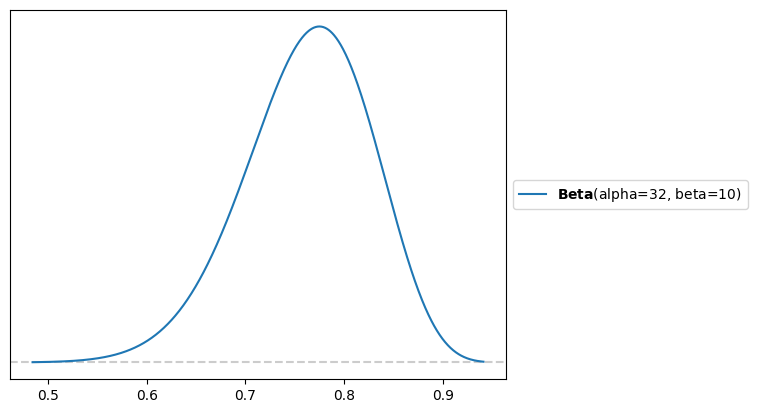

In [ ]:
pz.Beta(alpha=winprior,beta=lossprior).plot_pdf()

Looking at the graph, we can see that the peak is pretty similar to the expected percentage (76.2%).

# **Likelihood Distribution**

In our prior data analysis, we estimated a 76.2% chance of Hikaru winning a game. This was based off of the game data that we were given for Hikaru in the year 2014.

Now that we have our prior analysis done, we can import our second dataset which is the dataset that includes the data for Hikaru's games from 2015 to the present.

We can start by first assigning the raw data link which we get from the github repo and then reading that link into pandas. Then similarly to what we did with the prior data we need to limit the opponent's Elo to above 2500 because any Elo that is lower can be considered a significant disadvantage when they play against Hikaru (meaning that they will likely lose and bias the data).

In [ ]:
# read in the hikaru games dataset
hikarugames = 'https://github.com/amanmeka/DataScience/raw/refs/heads/main/HikaruBlitzData.csv'

hikaru = pd.read_csv(hikarugames)
hikaru = hikaru.query("opponentRating > 2500")

In [ ]:
hikaru

,userAccuracy,opponentAccuracy,gameUrl,gameId,timeClass,fen,userColor,userRating,opponent,opponentRating,opponentUrl,result,wonBy,date,openingUrl,opening,startTime,endTime,outcome,moveCount
0,78.45,82.39,https://www.chess.com/game/live/142489496438?r...,142489496438,blitz,8/8/7R/4k1P1/7P/5PK1/8/r7 w - - 7 86,black,3395,Karthusgaming,2821,https://www.chess.com/member/Karthusgaming,win,timeout,2025.08.29,https://www.chess.com/openings/Modern-Defense-...,Modern Defense with 1 e4 2.d4 Bg7 3.Nf3 d6 4.h3,18:11:19,18:16:56,85.0,timeout
1,82.13,80.64,https://www.chess.com/game/live/142460419390?r...,142460419390,blitz,1r5k/4b3/p2p4/PrpPp3/2R2qPp/1PNR1P1P/6K1/4Q3 b...,white,3390,AurenChess,2794,https://www.chess.com/member/AurenChess,win,resigned,2025.08.29,https://www.chess.com/openings/Modern-Defense-...,Modern Defense with 1 e4...3.Nf3 d6 4.Bc4 a6,1:30:57,1:35:53,44.0,resigned
2,86.34,81.01,https://www.chess.com/game/live/142460043512?r...,142460043512,blitz,8/8/2k3p1/2P5/p4PpP/P5P1/2Kpp3/3Rr3 w - - 0 52,black,3383,AurenChess,2801,https://www.chess.com/member/AurenChess,win,resigned,2025.08.29,https://www.chess.com/openings/Kings-Indian-At...,Kings Indian Attack Double Fianchetto Variatio...,1:11:22,1:16:24,51.0,resigned
3,86.90,82.48,https://www.chess.com/game/live/142490093186?r...,142490093186,blitz,3r3r/q4nkp/5p1b/p1p1pPp1/P1NpP1Q1/1P1P2P1/2PB2...,white,3400,Karthusgaming,2816,https://www.chess.com/member/Karthusgaming,win,resigned,2025.08.29,https://www.chess.com/openings/Kings-Indian-At...,Kings Indian Attack Yugoslav Variation...5.b3 ...,18:28:42,18:31:34,35.0,resigned
4,86.96,71.80,https://www.chess.com/game/live/142460219090?r...,142460219090,blitz,r1b1k2r/pp2ppbp/2n3p1/1N6/4QB2/q3P3/P1P1NPPP/1...,white,3386,AurenChess,2798,https://www.chess.com/member/AurenChess,win,resigned,2025.08.29,https://www.chess.com/openings/Trompowsky-Atta...,Trompowsky Attack...3.Bf4 d5 4.e3 c5 5.Bd3,1:20:28,1:21:45,13.0,resigned
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42387,93.17,82.98,https://www.chess.com/game/live/1018376703?ref...,1018376703,blitz,3r4/1q3pkp/1Pp3p1/4Q3/8/P3P3/5PPP/1R4K1 b - -,white,2809,gmwesley_so,2589,https://www.chess.com/member/gmwesley_so,win,resigned,2015.01.03,https://www.chess.com/openings/London-System-3...,London System 3...c5 4.e3 Nc6,17:14:55,17:20:10,31.0,resigned
42388,93.39,89.79,https://www.chess.com/game/live/1018453803?ref...,1018453803,blitz,r1b3k1/pp2pp1p/6p1/3rq3/2B5/2Q1P2P/P1P2PP1/R4R...,white,2780,gmwesley_so,2651,https://www.chess.com/member/gmwesley_so,timeout,NaN,2015.01.03,https://www.chess.com/openings/Queens-Pawn-Ope...,Queens Pawn Opening Chigorin Variation...4.Bf4...,18:39:30,18:44:15,17.0,timeout
42389,96.72,92.53,https://www.chess.com/game/live/1018487186?ref...,1018487186,blitz,3b4/1r3k2/p5pp/1p6/6n1/1P2B3/P1B1NPK1/8 w - -,black,2764,gmwesley_so,2683,https://www.chess.com/member/gmwesley_so,win,resigned,2015.01.03,https://www.chess.com/openings/Ruy-Lopez-Openi...,Ruy Lopez Opening Cozio Defense...7.d4 exd4 8....,19:15:54,19:22:25,50.0,resigned
42390,97.02,96.84,https://www.chess.com/game/live/1018413981?ref...,1018413981,blitz,8/8/2b3p1/p2k1pP1/p1p2P2/2P5/1P3K2/5N2 w - -,black,2812,gmwesley_so,2576,https://www.chess.com/member/gmwesley_so,agreed,NaN,2015.01.03,https://www.chess.com/openings/Ruy-Lopez-Openi...,Ruy Lopez Opening Berlin lHermet Berlin Wall D...,17:56:00,18:06:33,73.0,agreed


Now that we have that done we see that we have more than enough data to use for our beta binomial predictive model.

Now that we have the data required to make a strong predictive model, we need to see how many wins and not wins there are. Not wins consist of losses and draws, anything that is not a win.

In [ ]:
win = hikaru.query('result == "win"').shape[0]
loss = hikaru.query('result == "resigned"').shape[0]
loss += hikaru.query('result == "checkmated"').shape[0]
loss += hikaru.query('result == "timeout"').shape[0]
loss += hikaru.query('result == "abandoned"').shape[0]
loss += hikaru.query('result == "50move"').shape[0]
loss += hikaru.query('result == "repetition"').shape[0]
loss += hikaru.query('result == "insufficient"').shape[0]
loss += hikaru.query('result == "timevsinsufficient"').shape[0]
loss += hikaru.query('result == "stalemate"').shape[0]
loss += hikaru.query('result == "agreed"').shape[0]

total = win + loss

In [ ]:
win

28884

In [ ]:
loss

9120

Now that we have the data filtered into only two outcomes, we can use this to make a likelihood distribution using a binomial distribution function. The reason that we would want to create a likelihood distribution is so that we can visualize the likelihood of a certain number of successes occuring. In other words, we want to see how likely each success rate is. Each point on the binomial distribution is one of the many possibile success numbers.

<Axes: >

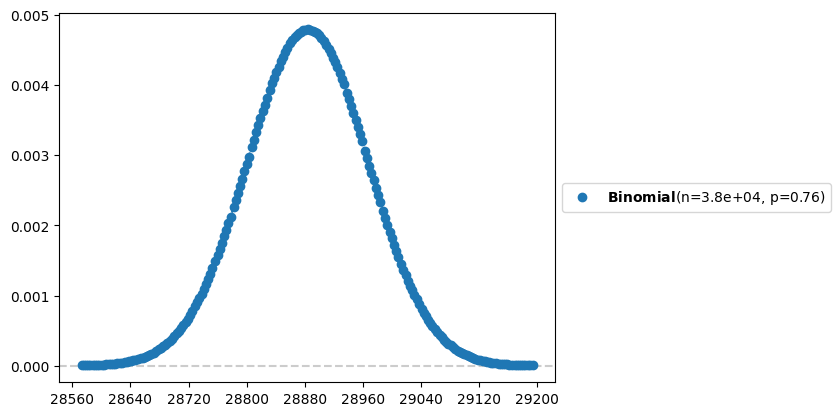

In [ ]:
pz.Binomial(n = 38004, p = 28884/38004).plot_pdf()

# **Posterior Prediction**

By looking at our prior mean from the prior data, we can say that ther is a 76.2% chance of success (or winning). But in order to have a solid predictive model we need to use the games that are more recent and in a larger number. We can't use ~40 games to make a reliable prediction model.

What we can do is use the larger dataset with ~38000 games and substitute them into the sampler below. By replacing the win and loss values we can model a prediction based on the data that we have. The code below is making a sample for a posterior using the PYMC library. I will use this to visualize the posterior on a graph later on.

In [ ]:
#setting variables to win and loss respectively.
w = win
l = loss

# the w value is 28884 but i am using a variable to make it more streamlined
wins = np.repeat(1, w)
# the l value is 9120 but i am using a variable to make it more streamlined
losses = np.repeat(0, l)

# combining all of the data into a data variable
data = np.concatenate( [wins,losses] )

with pm.Model() as hikarumodel:
  # beta prior
  θ = pm.Beta('θ' , alpha = 32. , beta = 10.)

  #likelihood using bernoulli distribution
  y = pm.Bernoulli('y', p = θ, observed = data)

  #the sample that we use for posterior
  hikarusample = pm.sample()

Output()

The code above essentially created a sample "packet" that we can now graph by using the plot_posterior command from the arviz library.

<Axes: title={'center': 'θ'}>

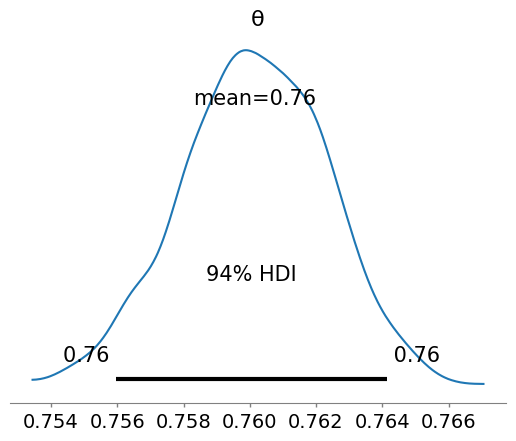

In [ ]:
az.plot_posterior(hikarusample)

# **Conclusion**

Looking at the graph above, we can make some conclusions:
* The likelihood of Hikaru winning a blitz chess game is around 76%
* This is extremely close to the mean of my prior which was 76.2%
* My posterior pretty closely resembles my prior data beta distribution
* Although my prior was pretty close to the likelihood, this might be because the prior data might have been too small of a data set.